In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

In [2]:
auctions = DataFetcher().fetch_auction_data()
prices = DataFetcher().fetch_historical_UST_data(date=datetime.datetime(year=2025, month=6, day=23))

In [3]:
ust_set = USTs(auction_data=auctions, price_data=prices)
ust_set = ust_set.get_current_UST_set(as_of_date=datetime.date(2025, 6, 23),
                                      get_ytms=True, include_FRNs=False, include_TIPS=False)

Merged auction and price data successfully
No missing or excess data
All CUSIPs are identical between DataFrames


In [4]:
ust_set

,Cusip,Security type,Rate,Maturity date,Buy,Sell,End of day,security_term,issue_date,EOD YTM
0,912797PT8,Bill,0.000,2025-06-24,0.000000,99.988361,100.000000,17-Week,2025-02-25,0.000000
1,912797NW3,Bill,0.000,2025-06-26,0.000000,99.965667,99.977556,26-Week,2024-12-26,0.045000
2,912797PU5,Bill,0.000,2025-07-01,99.908778,99.908667,99.920667,17-Week,2025-03-04,0.243000
3,912797NX1,Bill,0.000,2025-07-03,99.885833,99.885556,99.897000,26-Week,2025-01-02,0.207000
4,912797PZ4,Bill,0.000,2025-07-08,99.828750,99.828333,99.840167,17-Week,2025-03-11,0.490000
...,...,...,...,...,...,...,...,...,...,...
392,912810UA4,Bond,4.625,2054-05-15,96.187500,96.156250,95.812500,30-Year,2024-05-15,4.897057
393,912810UC0,Bond,4.250,2054-08-15,90.421875,90.406250,90.062500,30-Year,2024-08-15,4.893522
394,912810UE6,Bond,4.500,2054-11-15,94.390625,94.375000,94.000000,30-Year,2024-11-15,4.886160
395,912810UG1,Bond,4.625,2055-02-15,96.437500,96.406250,96.062500,30-Year,2025-02-18,4.876980


/tmp/ipykernel_30959/1991420672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['days to expiry'] = (filtered_data['Maturity date'] - pd.Timestamp.today().normalize()).dt.days


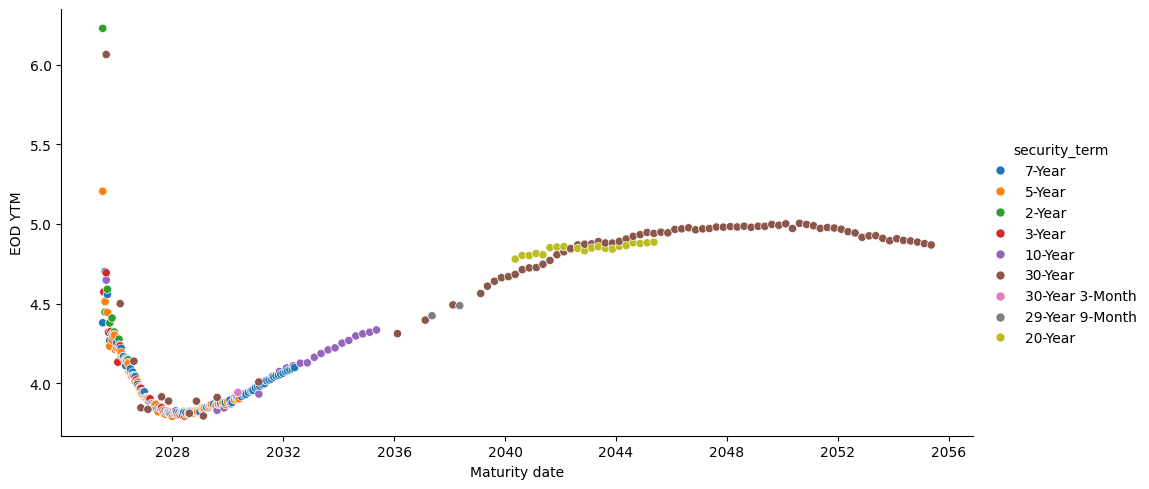

In [14]:
filtered_data = ust_set[ust_set['Security type'] != 'Bill']
filtered_data['days to expiry'] = (filtered_data['Maturity date'] - pd.Timestamp.today().normalize()).dt.days
sns.relplot(data=filtered_data, x='Maturity date', y='EOD YTM', kind='scatter', hue='security_term', aspect=2, height=5)

In [17]:
filtered_data.head(20).sort_values(by='Maturity date')

,Cusip,Security type,Rate,Maturity date,Buy,Sell,End of day,security_term,issue_date,EOD YTM,days to expiry
50,912828XZ8,Note,2.750,2025-06-30,0.0,99.96875,99.96875,7-Year,2018-07-02,4.379540,5
51,912828ZW3,Note,0.250,2025-06-30,0.0,99.90625,99.90625,5-Year,2020-06-30,5.205294,5
52,91282CHL8,Note,4.625,2025-06-30,0.0,99.96875,99.96875,2-Year,2023-06-30,6.228329,5
53,91282CEY3,Note,3.000,2025-07-15,0.0,99.90625,99.90625,3-Year,2022-07-15,4.573319,20
54,91282CAB7,Note,0.250,2025-07-31,0.0,99.56250,99.56250,5-Year,2020-07-31,4.512353,36
55,912828Y79,Note,2.875,2025-07-31,0.0,99.84375,99.81250,7-Year,2018-07-31,4.702023,36
56,91282CHN4,Note,4.750,2025-07-31,0.0,100.03125,100.03125,2-Year,2023-07-31,4.446820,36
57,912828K74,Note,2.000,2025-08-15,0.0,99.62500,99.62500,10-Year,2015-08-17,4.647484,51
58,91282CFE6,Note,3.125,2025-08-15,0.0,99.78125,99.78125,3-Year,2022-08-15,4.693362,51
61,91282CHV6,Note,5.000,2025-08-31,0.0,100.06250,100.06250,2-Year,2023-08-31,4.590101,67
